In [23]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/TrueCue/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TrueCue


In [24]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

## Import latest Covid data from Our World in Data

In [25]:
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv') 
df.tail().T

,50931,50932,50933,50934,50935
iso_code,NaN,NaN,NaN,NaN,NaN
continent,NaN,NaN,NaN,NaN,NaN
location,International,International,International,International,International
date,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18
total_cases,696,696,696,696,696
new_cases,NaN,NaN,NaN,NaN,NaN
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,7,7,7,7,7
new_deaths,NaN,NaN,NaN,NaN,NaN
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN


## Extract new_cases: new confirmed cases of COVID-19

In [26]:
df_pvt=df.pivot(index='date', columns='iso_code', values='new_cases').fillna(0.)
df_pvt.tail()

iso_code,NaN,ABW,AFG,AGO,AIA,ALB,AND,ARE,ARG,ARM,ATG,AUS,AUT,AZE,BDI,BEL,BEN,BES,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BLZ,BMU,BOL,BRA,BRB,BRN,BTN,BWA,CAF,CAN,CHE,CHL,CHN,CIV,CMR,...,SLV,SMR,SOM,SRB,SSD,STP,SUR,SVK,SVN,SWE,SWZ,SXM,SYC,SYR,TCA,TCD,TGO,THA,TJK,TLS,TTO,TUN,TUR,TWN,TZA,UGA,UKR,URY,USA,UZB,VAT,VCT,VEN,VGB,VIR,VNM,YEM,ZAF,ZMB,ZWE
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-14,0.0,32.0,66.0,122.0,0.0,182.0,0.0,1315.0,13305.0,1058.0,0.0,31.0,1171.0,277.0,4.0,11737.0,0.0,0.0,11.0,1537.0,785.0,324.0,0.0,336.0,526.0,16.0,1.0,227.0,10220.0,2.0,0.0,4.0,206.0,1.0,4042.0,1439.0,1392.0,28.0,28.0,130.0,...,284.0,0.0,0.0,152.0,11.0,0.0,14.0,531.0,399.0,916.0,13.0,9.0,0.0,52.0,0.0,13.0,23.0,9.0,37.0,0.0,11.0,0.0,1632.0,0.0,0.0,81.0,5133.0,24.0,52517.0,325.0,0.0,0.0,635.0,0.0,3.0,3.0,0.0,2066.0,38.0,15.0
2020-10-15,0.0,26.0,32.0,192.0,0.0,203.0,195.0,1431.0,14932.0,0.0,1.0,24.0,1606.0,369.0,0.0,9579.0,67.0,0.0,0.0,1684.0,819.0,349.0,222.0,482.0,597.0,34.0,0.0,219.0,27235.0,5.0,1.0,3.0,0.0,0.0,2506.0,2724.0,1092.0,11.0,34.0,108.0,...,286.0,0.0,0.0,245.0,0.0,0.0,11.0,1410.0,707.0,970.0,19.0,10.0,0.0,57.0,0.0,8.0,11.0,13.0,39.0,0.0,27.0,2234.0,1671.0,0.0,0.0,124.0,5590.0,1.0,59386.0,316.0,0.0,0.0,614.0,0.0,0.0,9.0,1.0,1877.0,29.0,19.0
2020-10-16,0.0,30.0,0.0,166.0,0.0,257.0,0.0,1398.0,17096.0,1371.0,0.0,21.0,1396.0,530.0,0.0,5938.0,18.0,0.0,30.0,1600.0,914.0,333.0,0.0,569.0,613.0,63.0,0.0,178.0,28523.0,3.0,0.0,0.0,203.0,0.0,2345.0,2690.0,1124.0,36.0,40.0,0.0,...,295.0,7.0,0.0,203.0,9.0,0.0,11.0,1929.0,746.0,596.0,18.0,8.0,1.0,48.0,0.0,21.0,13.0,4.0,38.0,0.0,40.0,0.0,1693.0,5.0,0.0,48.0,5062.0,79.0,63785.0,309.0,7.0,0.0,464.0,0.0,1.0,2.0,0.0,1770.0,43.0,20.0
2020-10-17,0.0,4.0,47.0,250.0,0.0,289.0,187.0,1412.0,16546.0,1465.0,0.0,9.0,1691.0,509.0,2.0,0.0,0.0,0.0,8.0,1527.0,998.0,371.0,132.0,621.0,658.0,46.0,0.0,243.0,30914.0,1.0,0.0,0.0,0.0,0.0,2374.0,3087.0,1694.0,20.0,18.0,0.0,...,204.0,0.0,0.0,265.0,10.0,3.0,19.0,2075.0,836.0,0.0,13.0,9.0,0.0,56.0,1.0,11.0,31.0,10.0,40.0,0.0,47.0,0.0,1812.0,0.0,0.0,217.0,5992.0,33.0,70256.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2019.0,0.0,24.0
2020-10-18,0.0,15.0,68.0,126.0,0.0,273.0,0.0,1538.0,13510.0,1540.0,7.0,12.0,2040.0,528.0,5.0,0.0,0.0,0.0,0.0,1209.0,603.0,246.0,111.0,0.0,0.0,47.0,0.0,148.0,24062.0,0.0,0.0,9.0,0.0,0.0,2215.0,0.0,1813.0,30.0,26.0,0.0,...,191.0,0.0,0.0,227.0,0.0,0.0,10.0,1968.0,1624.0,0.0,19.0,3.0,0.0,46.0,1.0,4.0,22.0,7.0,41.0,0.0,40.0,5752.0,1723.0,0.0,0.0,121.0,6410.0,51.0,56611.0,540.0,0.0,2.0,289.0,0.0,6.0,2.0,2.0,1928.0,130.0,11.0


## Make a dataframe of the 14 day notification rate per 100_000 population

In [27]:
df_14_day=pd.DataFrame()
for col in df_pvt.columns:
  df_14_day[col]=df_pvt[col].rolling(window=14).sum()

df_14_day.fillna(0., inplace=True)

for col in df_14_day.columns[1:]:
  popn=(df.loc[(df.date=='2020-10-01') & (df.iso_code==col), 'population']/100000).values
  if len(popn) > 0:
    df_14_day[col]=df_14_day[col]/popn
  else:
    print (col)

df_14_day = df_14_day.T
df_14_day.head().T

SLB


,NaN,ABW,AFG,AGO,AIA
2019-12-31,0.0,0.000000,0.000000,0.000000,0.0
2020-01-01,0.0,0.000000,0.000000,0.000000,0.0
2020-01-02,0.0,0.000000,0.000000,0.000000,0.0
2020-01-03,0.0,0.000000,0.000000,0.000000,0.0
2020-01-04,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...
2020-10-14,0.0,276.305191,1.900929,4.816488,0.0
2020-10-15,0.0,273.495307,1.947167,5.196818,0.0
2020-10-16,0.0,268.812169,1.903498,5.701895,0.0
2020-10-17,0.0,235.093569,2.011388,6.030499,0.0


In [28]:
df_14_day.loc['ESP'].tail(10) # Spain no data on weekends, delivered too late for Fridays

2020-10-09    309.339474
2020-10-10    309.339474
2020-10-11    309.339474
2020-10-12    300.936056
2020-10-13    294.973030
2020-10-14    297.013463
2020-10-15    305.352717
2020-10-16    313.610695
2020-10-17    313.610695
2020-10-18    313.610695
Name: ESP, dtype: float64

## Colour scales

In [29]:
cut_labels=['<20','20-59.9','60-119.9','120-239.9','240-479.9','>480']
cut_bins = [-1, 20., 60., 120., 240., 480., 2000.]
color_dict={'<20':'lemonchiffon','20-59.9':'yellow','60-119.9':'orange','120-239.9':'sandybrown','240-479.9':'brown','>480':'red'}

iso_3166=pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/slim-3/slim-3.csv',
                     dtype={'name':'str','alpha-3':'str','country-code':'float64'})

cells = pd.read_csv("https://raw.githubusercontent.com/mattdzugan/World-Population-Cartogram/master/data/year_2018__cell_500k/squares_and_triangles/cells.csv")

images=[]

## Plot for each day

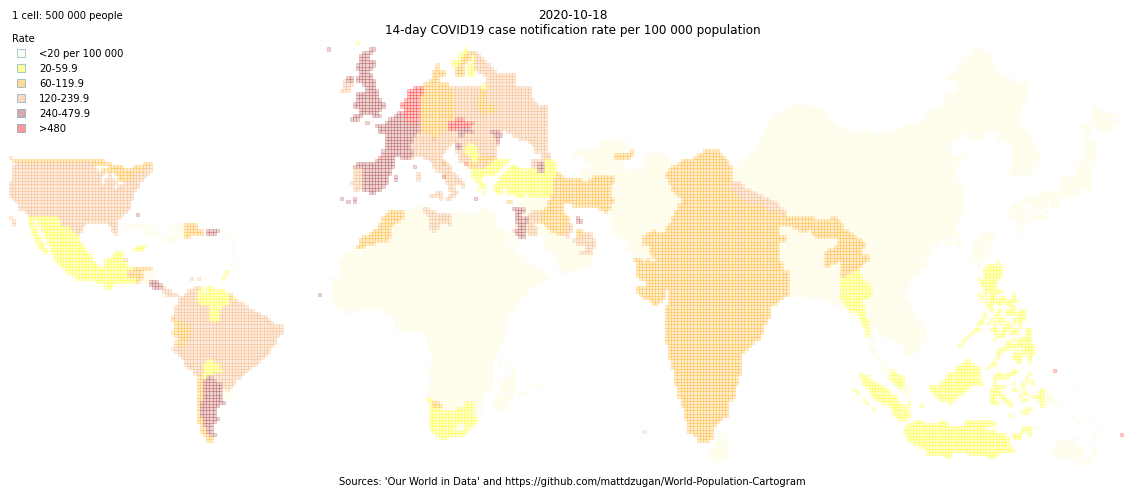

In [30]:
#for date in df_14_day.columns[[-1*(1+i*1) for i in range((pd.to_datetime(df_14_day.columns[-1])-pd.to_datetime('2020-04-30')).days)][::-1]]:
for date in [df_14_day.columns[-1]]:
  one_day_df = pd.DataFrame(df_14_day[date])
  one_day_df['count'] = pd.cut(one_day_df[date], bins=cut_bins, labels=cut_labels)
  one_day_df['color'] = one_day_df['count'].map(color_dict)
  one_day_df = one_day_df.reset_index().rename(columns={'index':'CountryCode'})
  one_day_df = one_day_df.merge(iso_3166, left_on='CountryCode', right_on='alpha-3', how='left')
  one_day_df['country-code'] = one_day_df['country-code'].fillna(0).astype('int')

  cells_day = cells.merge(one_day_df[['country-code','color']], left_on='CountryCode', right_on='country-code', how='left')
  cells_day.color.fillna('lemonchiffon',inplace=True)

  fig = plt.figure(figsize=(16,7))
  ax = fig.add_subplot(111, aspect='equal')
  plt.xlim([0, max(cells_day["X"]+1)])
  plt.ylim([0, max(cells_day["Y"]+1)])
  n=cells_day.shape[0]
  patches = []
  for i in range(0,n):
    patches.append(Rectangle((cells_day.loc[i,"X"]+.5, cells_day.loc[i,"Y"]+.5),1,1))
  ax.add_collection(PatchCollection(patches, color=cells_day.color, alpha=0.2))

  sq1 = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor="lemonchiffon")
  sq2 = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor="yellow")
  sq3 = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor="orange")
  sq4 = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor="sandybrown")
  sq5 = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor="brown")
  sq6 = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=8, markerfacecolor="red")

  plt.legend((sq1, sq2, sq3, sq4, sq5, sq6), ('<20 per 100 000','20-59.9','60-119.9','120-239.9','240-479.9','>480'),
             numpoints=1, loc=(.0,.77), title='1 cell: 500 000 people\n\nRate', fontsize=10, frameon=False)
  title = date+'\n14-day COVID19 case notification rate per 100 000 population'
  plt.title(title)
  plt.axis('off')
  plt.figtext(0.5, 0.01, "Sources: 'Our World in Data' and https://github.com/mattdzugan/World-Population-Cartogram", ha='center')
  plt.tight_layout()
  plt.savefig('./world_cartogram/pngs/'+date, dpi=300)
  plt.show()
  plt.close()

# Write contents of the 'pngs' directory to a .gif
(very slow)

In [31]:
!pip install pygifsicle 
!apt install gifsicle

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gifsicle is already the newest version (1.91-2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [32]:
import os
import imageio
from pygifsicle import optimize

In [33]:
png_dir = '/content/drive/My Drive/TrueCue/world_cartogram/pngs/'
images = []

for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

imageio.mimwrite('./world_cartogram/carto.gif', images, format='.gif', fps=10, loop=1)
optimize('carto.gif') 